# **프로젝트: 한영 번역기 만들기**

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


### **Step 1. 데이터 다운로드**

---

아래 링크에서 **`korean-english-park.train.tar.gz`** 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)


준비물
```
$ mkdir -p ~/aiffel/s2s_translation
$ sudo apt -qq -y install fonts-nanum


```

In [2]:
#다만 matplotlib 라이브러리의 기본 폰트는 한국어를 지원하지 않아요!
#올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주도록 합시다.
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

In [3]:
path_to_file_ko = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.ko'
path_to_file_en = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.en'

다운로드받은 데이터를 읽어온 후, 형태를 확인

In [4]:
with open(path_to_file_ko, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(path_to_file_en, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


### **Step 2. 데이터 정제**

---

1) **`set`** 데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 합니다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하세요! 중복을 제거한 데이터를 **`cleaned_corpus`** 에 저장합니다.

 **잘못된 정제**

In [6]:
cleaned_corpos_kr = list(set(raw_ko))
cleaned_corpos_en = list(set(raw_en))

print(cleaned_corpos_kr[0])
print(cleaned_corpos_en[0])

이라크 모술에서는 2일 경찰서 외곽 경찰 검문소에서 발생한 자살폭탄테러로 경찰관 4명 포함 9명이 숨지고 46명이 다쳤다고 모술의 경찰관이 밝혔다.
The pollution is carried downstream by the Mississippi and comes from throughout the United States.


**잘된 정제**

In [7]:
cleaned_corpus = list(set(zip(raw_ko, raw_en)))

**출력**

In [8]:
cleaned_corpus[0]

('라고 현학봉 북한 외무성 미국국 부국장이 수요일 오후 말했다고 보도되었다.',
 '“There is a delay in the implementation of economic compensation obligations to be undertaken by the other countries in the six-party talks,” Hyun Hak Bong, deputy director of the North Korean Foreign Ministry´s American affairs bureau, was quoted as saying late on Wednesday.')

In [9]:
#94123 -> 78968  
print(len(cleaned_corpus))

78968


2) 앞서 정의한 **`preprocessing()`** 함수는 한글에 대해 동작하지 않습니다. **한글에 적용할 수 있는 정규식**을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 **`<start>`** 토큰과 **`<end>`** 토큰을 추가하고 **`split()`** 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 **`mecab`** 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

In [10]:
from konlpy.tag import Mecab
mecab = Mecab()

def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)


    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
    if s_token == False:
        sentence = mecab.morphs(sentence)
    else:
        sentence = sentence.split()
        
    
    return sentence


모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. **`cleaned_corpus`**로부터 **토큰의 길이가 40 이하인 데이터를 선별**하여 **`eng_corpus`**와 **`kor_corpus`**를 각각 구축하세요.

In [11]:
kor_corpus = []
eng_corpus = []

#num_examples = 6000

for tmp in cleaned_corpus:
    tmp_ko = preprocess_sentence(tmp[0])
    tmp_en = preprocess_sentence(tmp[1], s_token=True, e_token=True)
    if len(tmp_ko) <= 40:
        kor_corpus.append(tmp_ko)
        eng_corpus.append(tmp_en)

print(len(kor_corpus))
print(len(eng_corpus))
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])

66483
66483
Korean: ['최근', '이슬라마바드', '붉', '은', '사원', '에서', '는', '보안', '군', '과', '이슬람', '근본주의', '학생', '들', '이', '충돌', ',', '폭력', '사태', '를', '악화', '시켰', '다', '.']
English: ['<start>', 'militants', 'and', 'radical', 'students', 'holed', 'up', 'in', 'the', 'mosque', 'two', 'weeks', 'ago', 'after', 'a', 'battle', 'with', 'police', '.', '<end>']


In [12]:
for text in eng_corpus[0]:
    print(text+' | ',end="")

<start> | there | is | a | delay | in | the | implementation | of | economic | compensation | obligations | to | be | undertaken | by | the | other | countries | in | the | six | party | talks | , | hyun | hak | bong | , | deputy | director | of | the | north | korean | foreign | ministry | s | american | affairs | bureau | , | was | quoted | as | saying | late | on | wednesday | . | <end> | 

In [13]:
for text in kor_corpus[0]:
    print(text+' | ',end="")

라고 | 현 | 학봉 | 북한 | 외무성 | 미국 | 국 | 부국 | 장이 | 수요일 | 오후 | 말 | 했 | 다고 | 보도 | 되 | 었 | 다 | . | 

### **Step 3. 데이터 토큰화**

---

앞서 정의한 **`tokenize()`** 함수를 사용해 데이터를 텐서로 변환하고 각각의 **`tokenizer`**를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! *(최소 10,000 이상!)*

*난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.*

In [14]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [15]:
# 토큰화하기
# 훈련 데이터와 검증 데이터로 분리하기
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

#enc_train, enc_val, dec_train, dec_val = \train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("한국어 Vocab Size:", len(enc_tokenizer.index_word))
print("외국어 Vocab Size:", len(dec_tokenizer.index_word))


한국어 Vocab Size: 45423
외국어 Vocab Size: 39979


### **Step 4. 모델 설계**

---

한국어를 영어로 잘 번역해 줄 멋진 **Attention 기반 Seq2seq 모델을 설계**하세요! 앞서 만든 모델에 **`Dropout`** 모듈을 추가하면 성능이 더 좋아질 거랍니다! **`Embedding Size`**와 **`Hidden Size`**는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 #<your_src_vocab_size> # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1#<your_tgt_vocab_size> # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 128)
Decoder Output: (64, 39980)
Decoder Hidden State: (64, 128)
Attention: (64, 30, 1)


### **Step 5. 훈련하기**

### **Optimizer & Loss**

---

가장 큰 줄기를 먼저 보고, 점점 더 들어가 보는 방식으로 진행해볼게요. 첫 순서는 **Optimizer와 Loss**입니다!

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### 훈련하기 train_step 구현하기
train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.

- **`@tf.function`**
데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 
- [텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)

- **`tf.GradientTape()`**
 는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다.    
- [텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)

본론으로 돌아와서 **`train_step()`**의 학습 과정은 아래와 같습니다.

1. Encoder에 소스 문장을 전달해 **컨텍스트 벡터인 `enc_out` 을 생성**
2. Decoder에 입력으로 전달할 **`<start>` 토큰 문장 생성**
3. **t=0일 때**, Decoder의 Hidden State는 **Encoder의 Final State로 정의**. **`h_dec = enc_out[:, -1]`**
4. **`<start>`** 문장과 enc_out, Hidden State를 기반으로 **다음 단어(t=1)를 예측**. **`pred`**
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 **정답 단어를 다음 입력으로 사용** (예측 단어 X)
6. **반복!**

In [21]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

훈련엔 위에서 사용한 코드를 그대로 사용하되, **`eval_step()`** 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 **본인이 생각하기에 가장 멋지게 번역한 Case를 제출**하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

In [22]:
enc_train = enc_tensor
dec_train = dec_tensor

In [23]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 60

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 60: 100%|██████████| 1039/1039 [04:26<00:00,  3.90it/s, Loss 0.5022]


In [138]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


In [165]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 15}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [166]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, str(sentence).split(), str(result).split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is in the president . <end> 


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


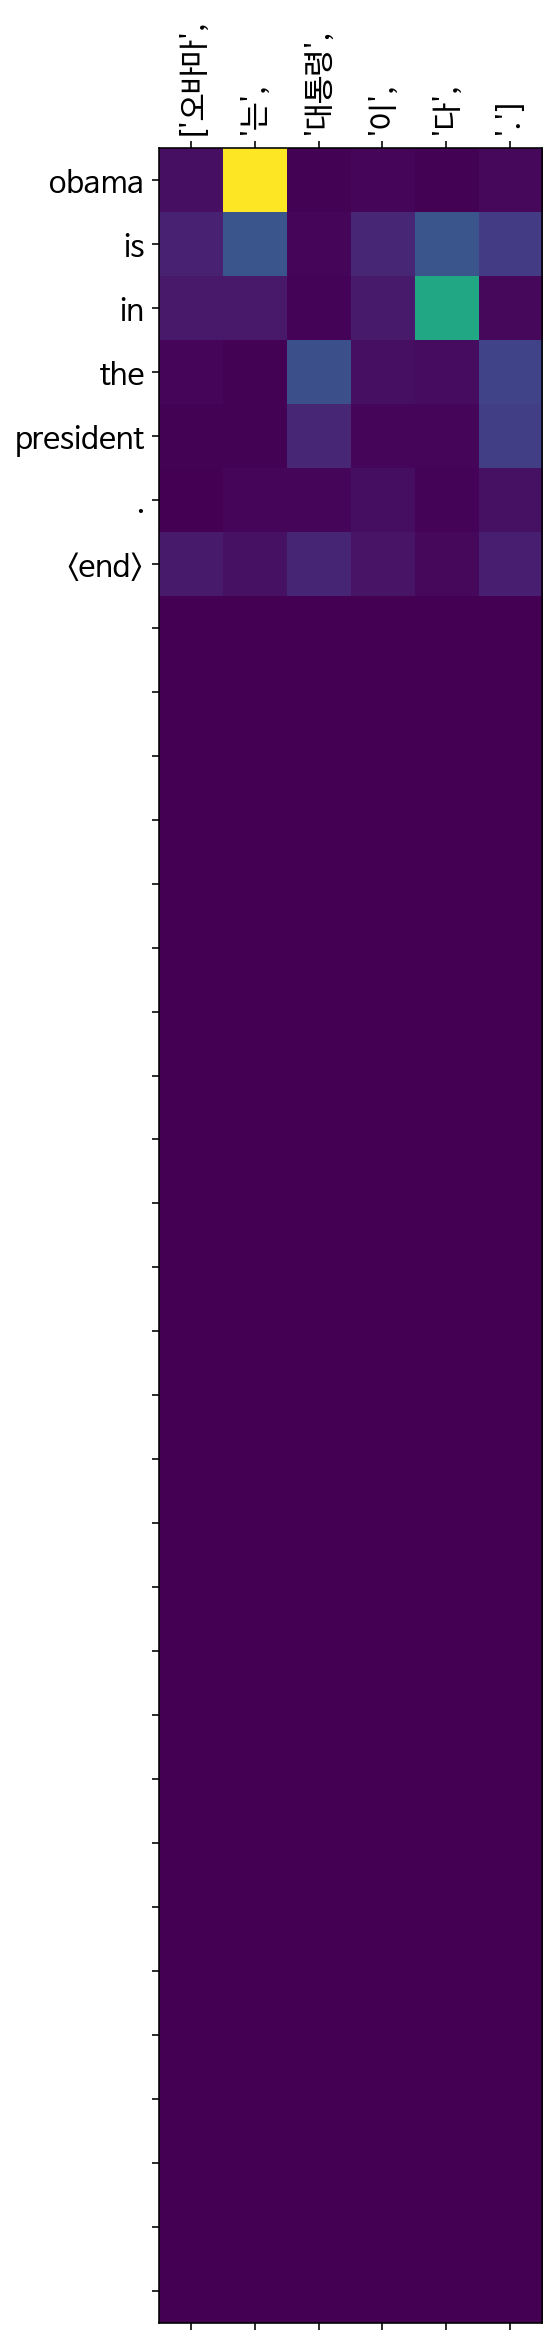

In [167]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they also a close at three days . <end> 


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


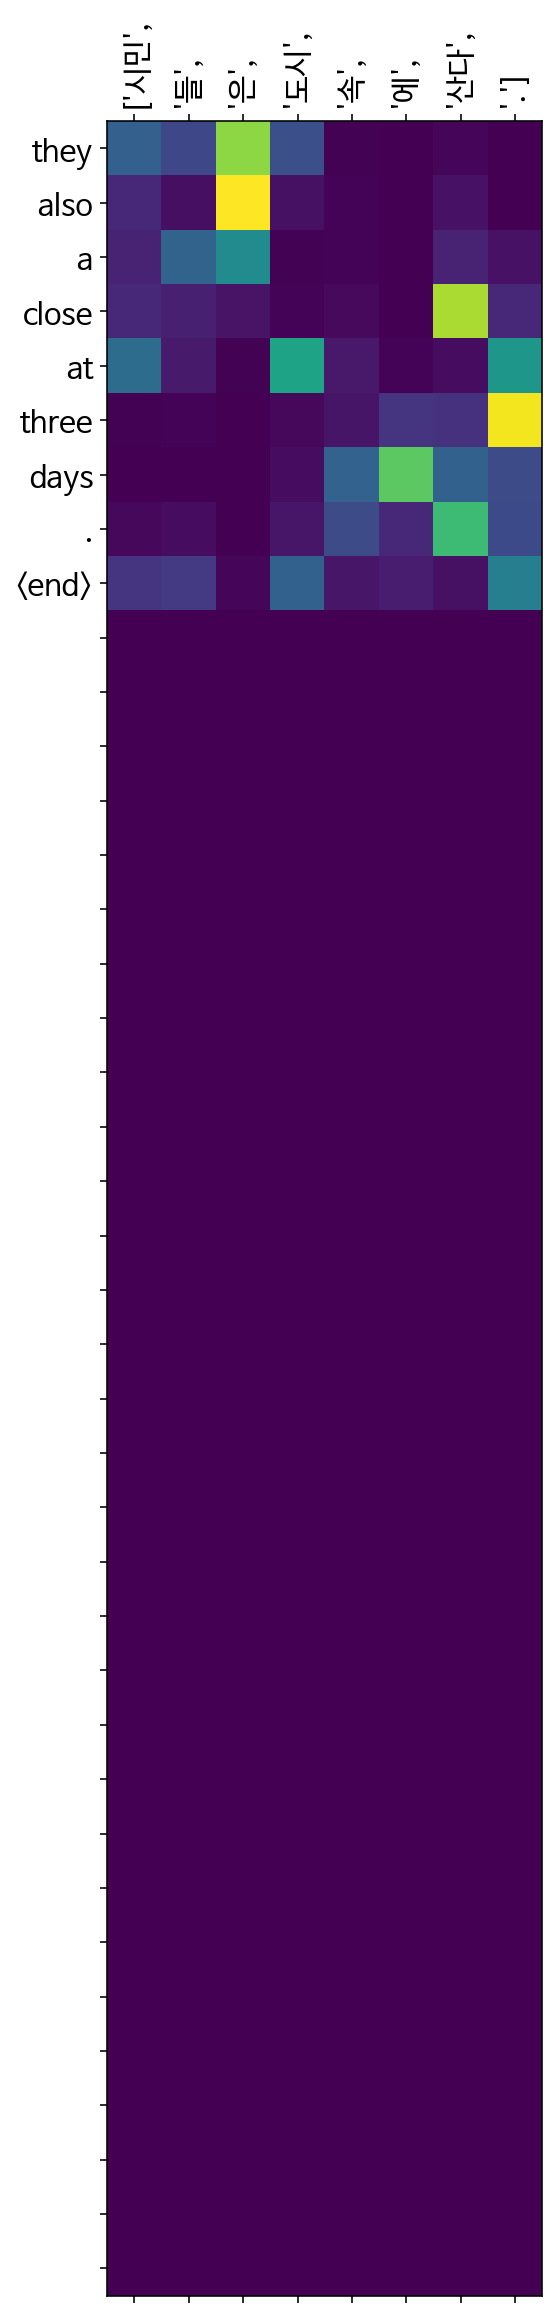

In [168]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: there is no word . <end> 


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


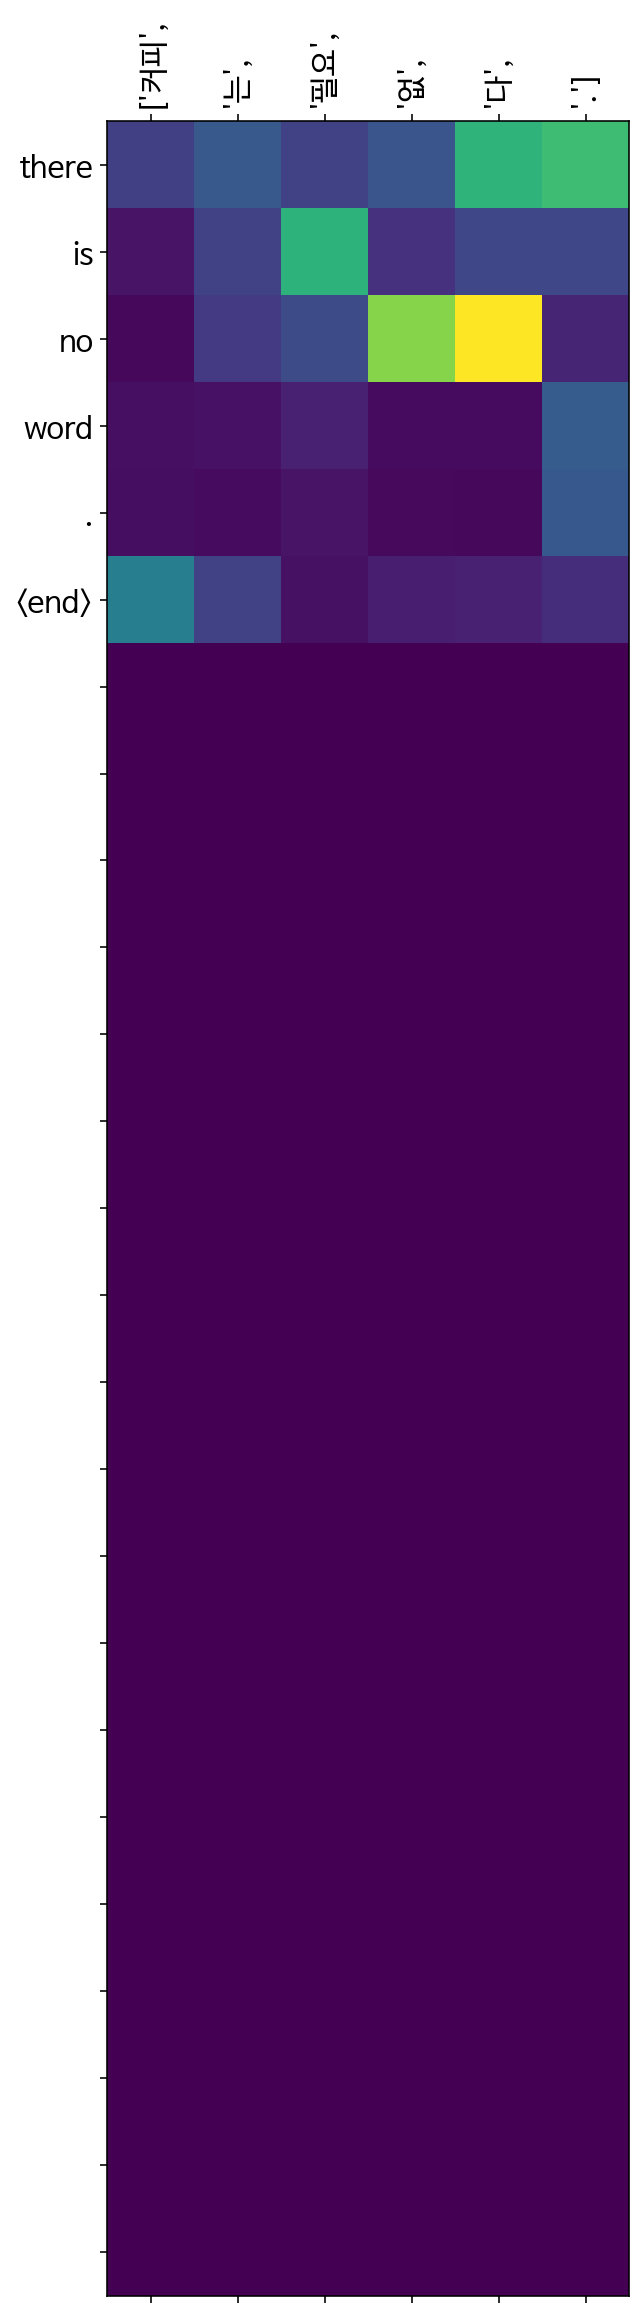

In [169]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people died in the blasts . <end> 


/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


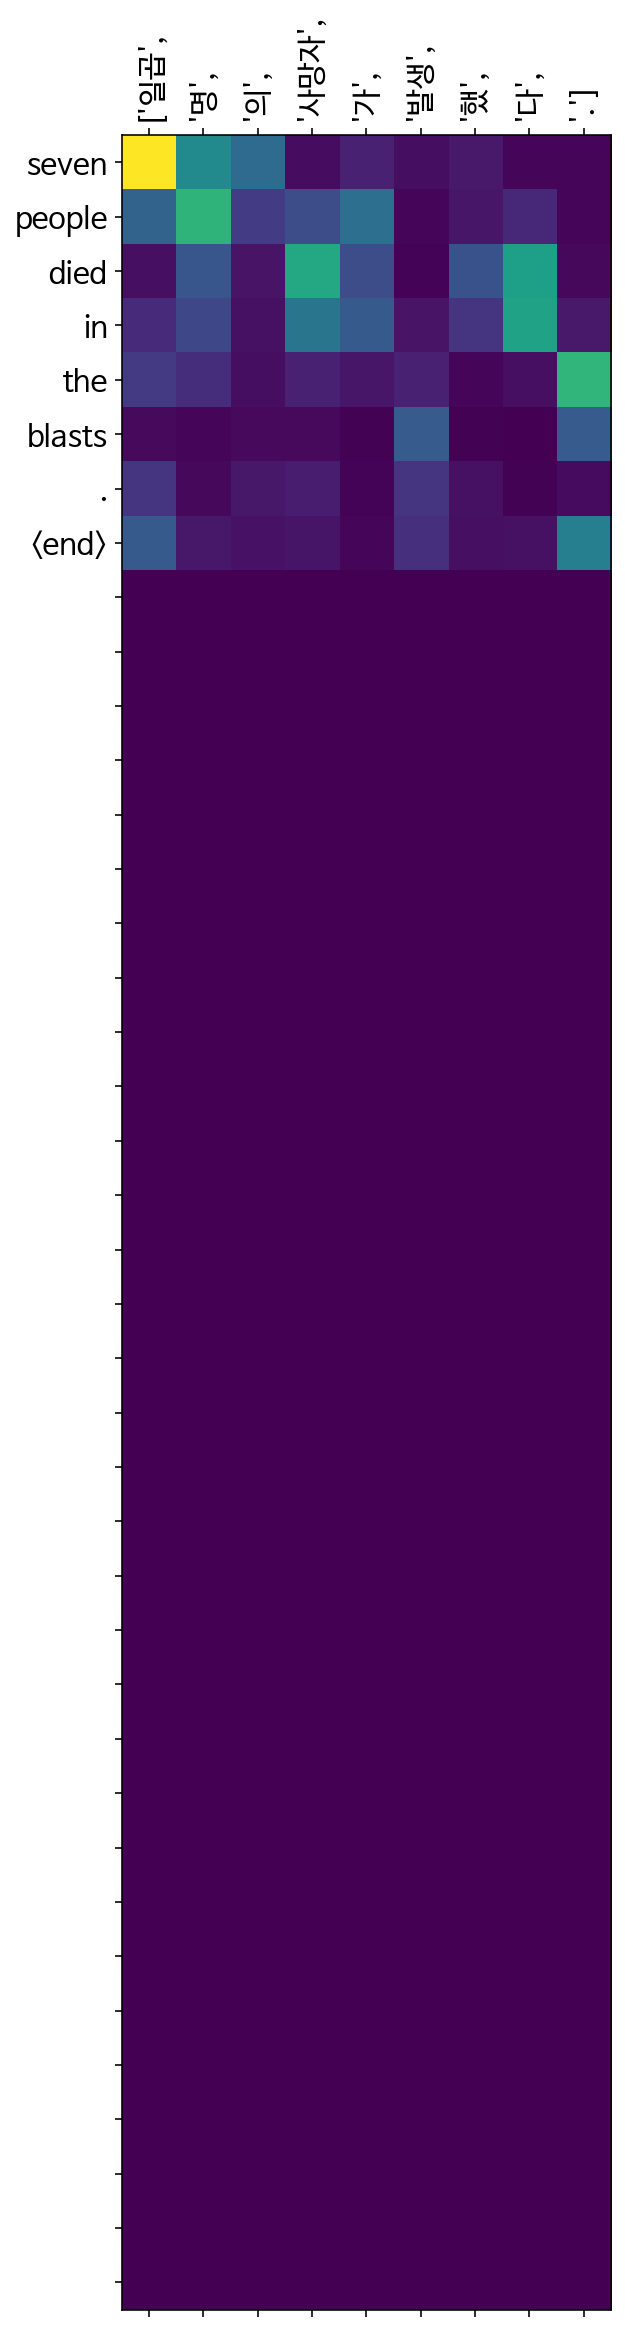

In [170]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

- 에포크 5일때 the the... the...the 로 번역됨

- 설정값
 ```
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 #<your_src_vocab_size> # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1#<your_tgt_vocab_size> # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

sequence_len = 30
```
- 에포크 60으로 설정 1애폭당 4분 => 모델 학습에 240분 걸림


```
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>

```

![https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-P-4.max-800x600.jpg](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-P-4.max-800x600.jpg)

아래의 기준을 바탕으로 프로젝트를 평가합니다.    
**평가문항**       
**상세기준**   

**1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.**    
구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

**2. Attentional Seq2seq 모델이 정상적으로 구동된다.**      
seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.

**3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.**    
테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

정규표현식 표현     
https://velog.io/@ednadev/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%A0%95%EA%B7%9C%ED%91%9C%ED%98%84%EC%8B%9D%EA%B3%BC-re%EB%AA%A8%EB%93%88

- **`@tf.function`**
데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 
- [텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)



- **`tf.GradientTape()`**
 는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다.    
- [텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)